In [ ]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=4e1f9a026f04542a6ce3c7e81111c342281f119ced6b3f45f93fad7f65beab51
  Stored in directory: /root/.cache/pip/wheels/b3/50/6c/0a82c1358b4da2dbd9c1bb17e0f89467db32812ab236dbf6d5
Successfully built gym
  Attempting uninstal

Mặc dù AlexNet đã chứng minh rằng các mạng nơ-ron tích chập có thể đạt được kết quả tốt, nó lại không cung cấp một khuôn mẫu chung để định hướng nghiên cứu sau này trong việc thiết kế các mạng mới. Trong các phần tiếp theo, chúng ta sẽ giới thiệu một số khái niệm dựa trên thực nghiệm được sử dụng rộng rãi khi thiết kế mạng học sâu.

Sự phát triển trong lĩnh vực này có nét tương đồng tiến triển trong ngành thiết kế vi xử lý, chuyển từ việc sắp đặt các bóng bán dẫn, đến các phần tử logic và các khối logic.

Tương tự như vậy, việc thiết kế kiến trúc các mạng nơ-ron đã phát triển theo hướng ngày một trừu tượng hơn. Điển hình là việc các nhà nghiên cứu đã thay đổi suy nghĩ từ quy mô các nơ-ron riêng lẻ sang các tầng, và giờ đây là các khối chứa các tầng lặp lại theo khuôn mẫu.

Ý tưởng sử dụng các khối lần đầu xuất hiện trong mạng VGG, được đặt theo tên của nhóm VGG thuộc Đại học Oxford. Sử dụng bất kỳ các framework học sâu hiện đại nào với vòng lặp và chương trình con để xây dựng các cấu trúc lặp lại này là tương đối dễ dàng.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 8.2.1. Khối VGG

Khối xây dựng cơ bản của CNN là một chuỗi các thành phần sau: (i) lớp tích chập có đệm để duy trì độ phân giải, (ii) lớp phi tuyến như ReLU, (iii) lớp gộp như gộp tối đa để giảm độ phân giải. Một trong những vấn đề với phương pháp này là độ phân giải không gian giảm khá nhanh. Đặc biệt, điều này áp đặt một giới hạn cứng của $\log_2 d$
các lớp tích chập trên mạng trước tất cả các kích thước ($d$) được sử dụng hết. Chẳng hạn, trong trường hợp của ImageNet, không thể có nhiều hơn 8 lớp tích chập theo cách này.

Trong bài báo gốc của VGG [Simonyan & Zisserman, 2014], tác giả sử dụng tích chập với các hạt nhân $3×3$ và tầng gộp cực đại $2×2$ với sải bước bằng $2$ (giảm một nửa độ phân giải sau mỗi khối). Trong mã nguồn dưới đây, ta định nghĩa một hàm tên vgg_block để tạo một khối VGG. Hàm này nhận hai đối số num_convs và num_channels tương ứng lần lượt với số tầng tích chập và số kênh đầu ra.

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

# 8.2.2. Mạng VGG

Giống như AlexNet và LeNet, Mạng VGG có thể được chia thành hai phần: phần đầu tiên bao gồm hầu hết các lớp tích chập và tổng hợp và phần thứ hai bao gồm các lớp được kết nối đầy đủ giống hệt với các lớp trong AlexNet. Sự khác biệt chính là các lớp tích chập được nhóm lại trong các phép biến đổi phi tuyến tính để không thay đổi kích thước, theo sau là bước giảm độ phân giải, như được mô tả trong hình dưới.

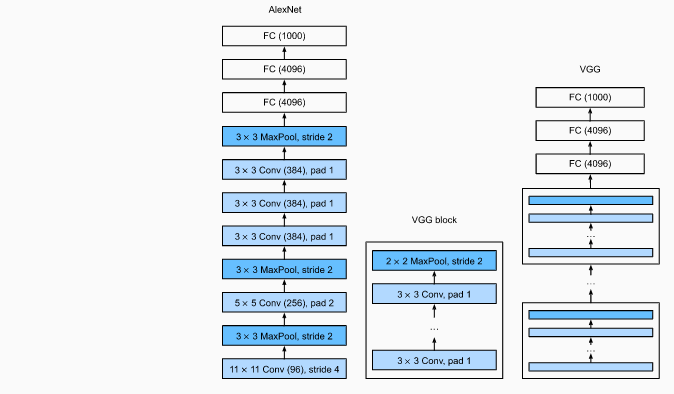

Phần tích chập của mạng liên tiếp kết nối một số khối VGG từ hình trên (cũng được xác định trong hàm vgg_block). Nhóm các tích chập này là một mô hình hầu như không thay đổi trong thập kỷ qua, mặc dù sự lựa chọn cụ thể của các hoạt động đã trải qua những sửa đổi đáng kể. Biến conv_arch bao gồm một danh sách các bộ (một bộ trên mỗi khối), trong đó mỗi bộ chứa hai giá trị: số lớp tích chập và số kênh đầu ra, chính xác là các đối số cần thiết để gọi hàm vgg_block. Như vậy, VGG xác định một nhóm mạng thay vì chỉ là một biểu hiện cụ thể. Để xây dựng một mạng cụ thể, chúng tôi chỉ cần lặp lại archđể soạn các khối.

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

Mạng VGG ban đầu có 5 khối tích chập, trong đó hai khối đầu tiên có một lớp tích chập và ba khối sau mỗi khối có hai lớp tích chập. Khối đầu tiên có 64 kênh đầu ra và mỗi khối tiếp theo nhân đôi số kênh đầu ra, cho đến khi con số đó đạt 512. Vì mạng này sử dụng 8 lớp tích chập và 3 lớp được kết nối đầy đủ nên nó thường được gọi là VGG-11.

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


Như bạn có thể thấy, chúng ta giảm một nửa chiều cao và chiều rộng ở mỗi khối, cuối cùng đạt chiều cao và chiều rộng là 7 trước khi làm phẳng các biểu diễn để phần được kết nối đầy đủ của mạng xử lý. Simonyan và Zisserman ( 2014 ) đã mô tả một số biến thể khác của VGG. Trên thực tế, nó đã trở thành tiêu chuẩn để đề xuất các họ mạng có sự đánh đổi về độ chính xác tốc độ khác nhau khi giới thiệu một kiến ​​trúc mới.

# 8.2.3. Đào tạo.

Vì VGG-11 đòi hỏi tính toán cao hơn AlexNet nên chúng ta xây dựng một mạng có số lượng kênh nhỏ hơn. Điều này là quá đủ để đào tạo về Fashion-MNIST. Quy trình đào tạo mô hình tương tự như quy trình của AlexNet trong Phần 8.1 . Một lần nữa quan sát sự phù hợp chặt chẽ giữa xác nhận và mất đào tạo, chỉ đề xuất một lượng nhỏ trang bị quá mức.

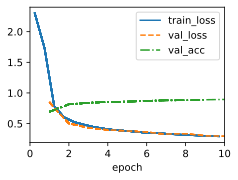

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)